# NLP Project

## Load Data

### Scraped CDP Scores
See [./download_csp_scores.py](./download_cdp_scores.py) for the CDP scores scraping code

In [ ]:
import pandas as pd
import numpy as np
import platform
from transformers import pipeline
import tensorflow as tf
import torch
from flax import nnx
from transformers import AutoTokenizer, AutoModelForSequenceClassification
pd.options.display.max_colwidth = 100

/Users/jacksonmiskill/class/f24/nlp/project/venv-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-10 15:38:02.023005: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
p = platform.platform()

esg_documents_df = pd.read_csv('./dax_esg_media_dataset/esg_documents_for_dax_companies.csv', sep='|')
cdp_scores_df = pd.read_csv('./cdp_scores.csv')
esg_documents_df = esg_documents_df.drop("Unnamed: 0", axis=1)



In [4]:
# merge CDP score with the esg data so that we have a score for each document
merged_df = pd.merge(esg_documents_df, cdp_scores_df, how='left', left_on='symbol', right_on='Ticker')

merged_df.dropna(subset=['CDP Score'], inplace=True) # drop rows without a CDP score

# print(merged_df[['symbol', 'CDP Score']])
# print(len(merged_df))
s = merged_df.head(1)['content'].item() # this is how to get the text alone

In [6]:
# big companies that I know
# Adidas, Volkswagen, Porsche, Siemens (AG and Energy), Merck, Airbus, Puma, Allianz, Brenntag
# this is all records for Adidas
tmp = merged_df[merged_df['company'] == "Adidas AG"]

## Preprocessing

In [ ]:
"""
    Company level
    CDP Score
    A      9
    A-    12
    B     10
    C      3

    Records for each company level
    CDP Score
    A     2760
    A-    4870
    B     2208
    C      360

Counts of how many companies have each type of score

C companies, arguably the most important, don't have as much to train on

another idea is to train on these German companies and then test on American companies (the extra data
thing that I have)

runs out of iterations because our training data is huge (several entire documents per company)
maybe we need to generate a equitable dataset, like equal amounts of labeled data
for each company that we have in the 36 we were able to get a CDP score on maybe we take 1200 samples
we can use the ClimateBERT to label them as positive, neutral, or negative and then create the training data
one record for each sentence/ phrase
maybe we can limit each phrase to a certain length or just separate by sentences or something

"""

# climateBERT model from https://huggingface.co/climatebert/environmental-claims?library=transformers
# environmental claims model - I wasn't sure which one to pick from their suite of models, this one semantically made the most sense to me
# there were a bunch of other ones

from transformers import AutoTokenizer, AutoModelForSequenceClassification

climate_tokenizer = AutoTokenizer.from_pretrained("climatebert/environmental-claims")
climate_model = AutoModelForSequenceClassification.from_pretrained("climatebert/environmental-claims") # this only gives yes/no
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert") # this gives positive/neutral/negative

message = "carbon emissions increased by about 100%"

example_content = tmp.head(1)['content'].item()
sentences = example_content.split(".")

examples = {

    "positive": [],
    "neutral": [], # with the ClimateBERT model, there is no neutral classification
    "negative": []
}

# inputs = climate_tokenizer(message, return_tensors="pt")
# with torch.no_grad():
#     logits = climate_model(**inputs).logits
# predicted_class_id = logits.argmax().item()
# if predicted_class_id == 0:
#     print("positive")
# else:
#     print("negative")

for s in sentences:
    if len(examples['positive']) > 1200:
        break
    try:
        inputs = climate_tokenizer(s, return_tensors="pt")
        with torch.no_grad():
            logits = climate_model(**inputs).logits
        predicted_class_id = logits.argmax().item()
    except Exception as e:
        print("did not work for this iteration of sentence, skipping")
        continue
    if predicted_class_id == 0:
        examples['positive'].append(s)
    else:
        examples['negative'].append(s)
    


Token indices sequence length is longer than the specified maximum sequence length for this model (663 > 512). Running this sequence through the model will result in indexing errors


did not work for this iteration of sentence, skipping
did not work for this iteration of sentence, skipping
did not work for this iteration of sentence, skipping
did not work for this iteration of sentence, skipping


In [ ]:
from pprint import pprint
pprint(examples['negative'])

[' In addition to the continued digital transformation of the company, we are '
 'working closely with our partners in the global supply chain to reduce '
 'energy consumption and to increase the proportion of green energy we use',
 ' By 2025, nine out of every ten adidas articles should be made from more '
 'sustainable materials, while the carbon footprint per product should be '
 'reduced by 15%',
 ' adidas aims at operating climate neutral (CO2e) at its locations by 2025 '
 'and at reaching complete climate neutrality by 2050',
 ' Our ambition is that 90% of our articles will be sustainable by 2025',
 ' The majority of the environmentally preferred materials currently used are '
 'recycled materials and more sustainable cotton',
 ' The percentages of the required proportion of environmentally preferred '
 'materials of the article weight have been increased significantly, which '
 'corresponds to our ambition to significantly expand our commitment to '
 'sustainability in the years

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{2,}\b', # Only keep word tokens with at least 2 letters
    max_features=1000
)

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{2,}\b',
    max_features=1000,
)

count_vectorized_bow_matrix = count_vectorizer.fit_transform(merged_df['content'].fillna(''))

tfidf_vectorized_bow_matrix = tfidf_vectorizer.fit_transform(merged_df['content'].fillna(''))

y = merged_df['CDP Score']

In [6]:
# same first 10 features is OK
print(f"First 10 BoW features for CountVectorizer: {count_vectorizer.get_feature_names_out()[:10]}")
print(f"First 10 BoW features for TfidfVectorizer: {tfidf_vectorizer.get_feature_names_out()[:10]}")

First 10 BoW features for CountVectorizer: ['ability' 'able' 'access' 'accordance' 'according' 'account' 'accounting'
 'achieve' 'achieved' 'achievement']
First 10 BoW features for TfidfVectorizer: ['ability' 'able' 'access' 'accordance' 'according' 'account' 'accounting'
 'achieve' 'achieved' 'achievement']


## Model Fitting

In [7]:
# https://www.geeksforgeeks.org/text-classification-using-logistic-regression/#

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "Logistic Regression": LogisticRegression(random_state=1, max_iter=10000),
    "Support Vector Machine": LinearSVC(random_state=1, max_iter=10000),
    "Random Forest": RandomForestClassifier(random_state=1, n_estimators=100),
    "Multinomial Naive Bayes": MultinomialNB(),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=1),
    "PassiveAggressiveClassifier": PassiveAggressiveClassifier(max_iter=1000, random_state=1),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=1)
}

def analyze_models(bow_matrix):
    X_train, X_test, y_train, y_test = train_test_split(bow_matrix, y, test_size=0.25, random_state=1)
    trained_models = {}

    results = []
    for name, model in models.items():
        print(f"Training Model: {name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        result = {
            "Model": name,
            "Accuracy": accuracy,
            "Balanced Accuracy": balanced_accuracy,
            "Precision": report['weighted avg']['precision'],
            "Recall": report['weighted avg']['recall'],
            "F1-Score": report['weighted avg']['f1-score']
        }
        results.append(result)
        trained_models[name] = model
    
    results_df = pd.DataFrame(results)
    return results_df, trained_models

print(f'Training models on CountVectorizer BoW matrix')
count_vectorized_results_df, count_vectorized_models = analyze_models(count_vectorized_bow_matrix)
print(f'Training models on TF-IDF Vectorizer BoW matrix')
tfidf_vectorized_results_df, tfidf_vectorized_models = analyze_models(tfidf_vectorized_bow_matrix)

Training models on CountVectorizer BoW matrix
Training Model: Logistic Regression
Training Model: Support Vector Machine


/Users/jacksonmiskill/class/f24/nlp/project/venv-3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Model: Random Forest
Training Model: Multinomial Naive Bayes
Training Model: GradientBoostingClassifier
Training Model: PassiveAggressiveClassifier
Training Model: MLPClassifier
Training models on TF-IDF Vectorizer BoW matrix
Training Model: Logistic Regression
Training Model: Support Vector Machine
Training Model: Random Forest
Training Model: Multinomial Naive Bayes
Training Model: GradientBoostingClassifier
Training Model: PassiveAggressiveClassifier
Training Model: MLPClassifier


In [ ]:
count_vectorized_results_df.sort_values(by="Balanced Accuracy", ascending=False, inplace=True)
print('Results for Count Vectorized dataset')
count_vectorized_results_df

Results for Count Vectorized dataset


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score
4,GradientBoostingClassifier,0.896863,0.836457,0.899420,0.896863,0.895329
6,MLPClassifier,0.843137,0.765790,0.842829,0.843137,0.841805
2,Random Forest,0.871373,0.752951,0.873856,0.871373,0.866572
0,Logistic Regression,0.795294,0.716007,0.795759,0.795294,0.794893
1,Support Vector Machine,0.804706,0.714497,0.802336,0.804706,0.802393
5,PassiveAggressiveClassifier,0.782353,0.690065,0.783953,0.782353,0.781932
3,Multinomial Naive Bayes,0.603529,0.497268,0.659088,0.603529,0.598248


In [9]:
tfidf_vectorized_results_df.sort_values(by="Balanced Accuracy", ascending=False, inplace=True)
print('Results for Tfidf Vectorized dataset')
tfidf_vectorized_results_df

Results for Tfidf Vectorized dataset


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score
4,GradientBoostingClassifier,0.898039,0.839355,0.900204,0.898039,0.896537
5,PassiveAggressiveClassifier,0.834510,0.757694,0.834271,0.834510,0.833478
6,MLPClassifier,0.828235,0.751929,0.827101,0.828235,0.827342
2,Random Forest,0.867059,0.749849,0.869921,0.867059,0.862194
1,Support Vector Machine,0.836078,0.743833,0.835950,0.836078,0.833392
0,Logistic Regression,0.821961,0.704527,0.823645,0.821961,0.816725
3,Multinomial Naive Bayes,0.746275,0.576866,0.733168,0.746275,0.733334


(0.0, 1.0)

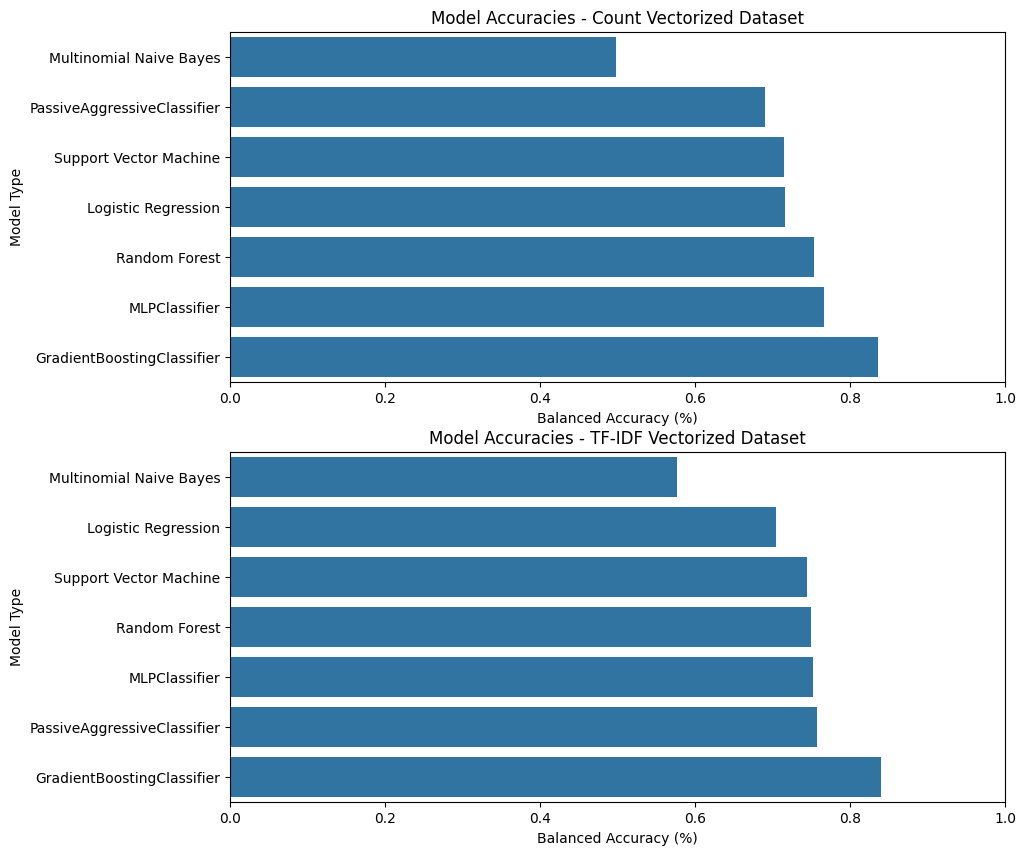

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# get 2 vertically stacked plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# count vectorized plot (top)
count_vectorized_results_df.sort_values(by="Balanced Accuracy", ascending=True, inplace=True)
sns.barplot(x="Balanced Accuracy", y="Model", data=count_vectorized_results_df, ax=ax1)
ax1.set_title("Model Accuracies - Count Vectorized Dataset")
ax1.set_xlabel('Balanced Accuracy (%)')
ax1.set_ylabel('Model Type')

# tfidf vectorized tlot (bottom)
tfidf_vectorized_results_df.sort_values(by="Balanced Accuracy", ascending=True, inplace=True)
sns.barplot(x="Balanced Accuracy", y="Model", data=tfidf_vectorized_results_df, ax=ax2)
ax2.set_title("Model Accuracies - TF-IDF Vectorized Dataset")
ax2.set_xlabel('Balanced Accuracy (%)')
ax2.set_ylabel('Model Type')

ax1.set_xlim(0, 1)
ax2.set_xlim(0, 1)

Text(0, 0.5, 'Model Type')

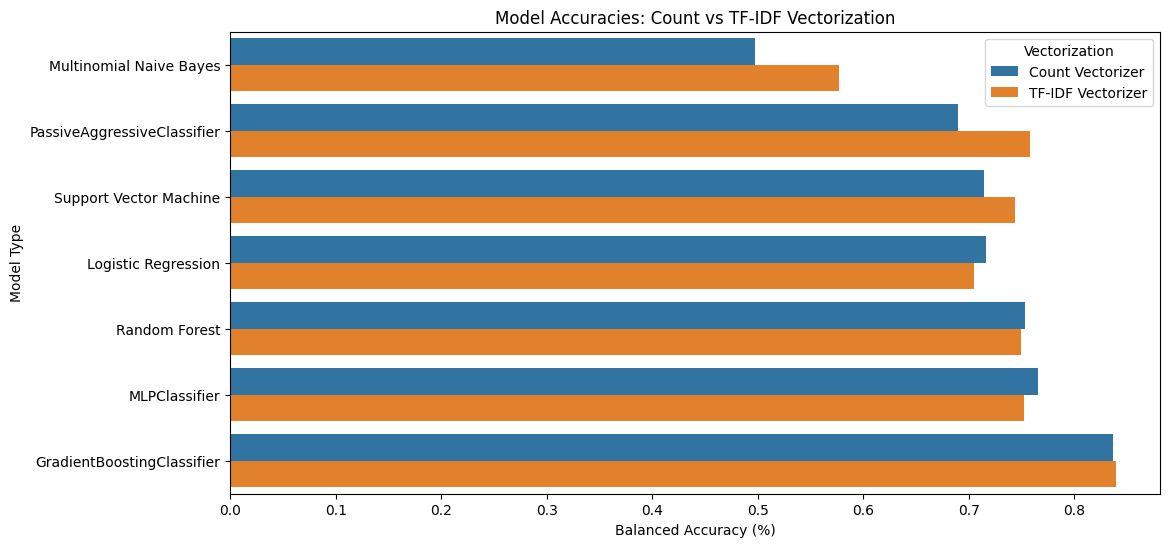

In [12]:
# Create a combined dataframe for plotting
combined_results_df = pd.concat([
    count_vectorized_results_df.assign(Vectorization='Count Vectorizer'),
    tfidf_vectorized_results_df.assign(Vectorization='TF-IDF Vectorizer')
])

# widen plot
plt.figure(figsize=(12, 6))

sns.barplot(x="Balanced Accuracy", y="Model", hue="Vectorization", data=combined_results_df)

# Customize the plot
plt.title("Model Accuracies: Count vs TF-IDF Vectorization")
plt.xlabel('Balanced Accuracy (%)')
plt.ylabel('Model Type')

The best model appears to be the `GradientBoostingClassifier`, trained on the TF-IDF vectorization of the texts. I'll now show some more evaluation information, then explore the best hyperparameter setting for this model.

In [13]:
from sklearn.metrics import balanced_accuracy_score, classification_report
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectorized_bow_matrix, y, test_size=0.25, random_state=1)

model = tfidf_vectorized_models["GradientBoostingClassifier"]
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy:\t\t{acc:.2%}')
print(f'Balanced Accuracy:\t{balanced_acc:.2%}')
print(f'Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy:		89.80%
Balanced Accuracy:	83.94%
Classification Report:
              precision    recall  f1-score   support

           A       0.95      0.81      0.87       718
          A-       0.88      0.97      0.92      1184
           B       0.90      0.89      0.89       550
           C       0.79      0.68      0.73        98

    accuracy                           0.90      2550
   macro avg       0.88      0.84      0.86      2550
weighted avg       0.90      0.90      0.90      2550



In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_distributions = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
}

grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=1),
    param_distributions,
    # n_iter=20,  # Number of parameter settings that are sampled
    cv=2,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=2  # Show progress
)

grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_gb_classifier = grid_search.best_estimator_

# Evaluate the best model
best_predictions = best_gb_classifier.predict(X_test)
print("\nBest Model Performance:")
print(classification_report(y_test, best_predictions))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time= 1.9min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time= 2.0min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time= 2.5min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time= 2.6min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 3.8min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 3.9min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time= 5.1min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 3.2min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 3.3min
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time= 5.2min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 2.0min
[CV] END ...learning_rate=0.1, max_depth=3, n_es

In [15]:
# Assuming grid_search is your GridSearchCV object
results = pd.DataFrame(grid_search.cv_results_)
# tfidf_vectorized_results_df.sort_values(by="Balanced Accuracy", ascending=True, inplace=True)
results.sort_values(by="rank_test_score", ascending=True, inplace=True)
results[["params", "mean_test_score"]]

# Extract relevant columns from cv_results_
columns_to_show = ['params', 'mean_test_score']
df_results = pd.DataFrame(grid_search.cv_results_)[columns_to_show]

# Expand the 'params' dictionary into separate columns
df_results = df_results.assign(**df_results.pop('params').apply(pd.Series))

# Sort by rank for better readability
df_results = df_results.sort_values('mean_test_score', ascending=False)

# Display the formatted DataFrame
df_results.reset_index(drop=True, inplace=True)
df_results


,mean_test_score,learning_rate,max_depth,n_estimators
0,0.826401,0.10,5.0,200.0
1,0.825873,0.10,3.0,200.0
2,0.825297,0.10,4.0,100.0
3,0.824983,0.10,4.0,200.0
4,0.819675,0.10,5.0,100.0
5,0.819596,0.10,3.0,100.0
6,0.761475,0.01,5.0,200.0
7,0.756839,0.01,4.0,200.0
8,0.726126,0.01,3.0,200.0
9,0.710325,0.01,5.0,100.0


In [17]:
# Evaluate the best model
best_predictions = best_gb_classifier.predict(X_test)
print("\nBest Model Performance:")
print(classification_report(y_test, best_predictions))


Best Model Performance:
              precision    recall  f1-score   support

           A       0.93      0.87      0.90       718
          A-       0.91      0.97      0.94      1184
           B       0.90      0.89      0.90       550
           C       0.78      0.64      0.70        98

    accuracy                           0.91      2550
   macro avg       0.88      0.84      0.86      2550
weighted avg       0.91      0.91      0.91      2550



In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


tokenizer_name = "ESGBERT/EnvironmentalBERT-environmental"
model_name = "ESGBERT/EnvironmentalBERT-environmental"
 
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, max_len=512)
 
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer) # set device=0 to use GPU
 
# See https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.pipeline
print(pipe("Scope 1 emissions are reported here on a like-for-like basis against the 2013 baseline and exclude emissions from additional vehicles used during repairs.", padding=True, truncation=True))


[{'label': 'environmental', 'score': 0.9979760050773621}]


TypeError: TrainingDataCreator.get_all_environmental_sentences() missing 1 required positional argument: 'merged_df'

In [ ]:
# this is the FinBERT model

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# examples of text we can feed the model in order for it to classify it
# these examples are from the DAX dataset we are looking at
positive_example = "we have reduced our carbon emissions by 12.7% (vs. 2018)"
neutral_example = "We are proud of this result"
negative_example = "We have increased our carbon emissions by 12.7% (vs. 2018), which is a very bad thing"
false_positive = "we have increased our carbon emissions by 12.7% (vs. 2018)"

message = "we increased our carbon emissions by 400% this year!"


inputs = tokenizer(neutral_example, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'neutral'

In [ ]:
# climateBERT model from https://huggingface.co/climatebert/environmental-claims?library=transformers
# environmental claims model - I wasn't sure which one to pick from their suite of models, this one semantically made the most sense to me
# there were a bunch of other ones

from transformers import AutoTokenizer, AutoModelForSequenceClassification

climate_tokenizer = AutoTokenizer.from_pretrained("climatebert/environmental-claims")
climate_model = AutoModelForSequenceClassification.from_pretrained("climatebert/environmental-claims")

message = "we increased our carbon emissions by 400% this year!"

inputs = climate_tokenizer(neutral_example, return_tensors="pt")

with torch.no_grad():
    logits = climate_model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]



'positive'

as we can see here, the second model correctly predicts the false positive whereas the first model does not

## Model Analysis

In [ ]:
# TODO check how well our model did here

# Data Sources
- https://www.kaggle.com/datasets/pritish509/s-and-p-500-esg-risk-ratings
- https://www.kaggle.com/datasets/equintel/dax-esg-media-dataset

# References
- https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.balanced_accuracy_score.html

# Scratch Work

In [ ]:
import pandas as pd
pd.read_csv("~/class/f24/nlp/project/sustain-nlp/sp500_esg_risk_ratings/sp500_esg_risk_ratings.csv")

,Symbol,Name,Address,Sector,Industry,Full Time Employees,Description,Total ESG Risk score,Environment Risk Score,Governance Risk Score,Social Risk Score,Controversy Level,Controversy Score,ESG Risk Percentile,ESG Risk Level
0,ENPH,"Enphase Energy, Inc.","47281 Bayside Parkway\nFremont, CA 94538\nUnit...",Technology,Solar,"3,157","Enphase Energy, Inc., together with its subsid...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EMN,Eastman Chemical Company,"200 South Wilcox Drive\nKingsport, TN 37662\nU...",Basic Materials,Specialty Chemicals,"14,000",Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,Moderate Controversy Level,2.0,50th percentile,Medium
2,DPZ,Domino's Pizza Inc.,"30 Frank Lloyd Wright Drive\nAnn Arbor, MI 481...",Consumer Cyclical,Restaurants,"6,500","Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,Moderate Controversy Level,2.0,66th percentile,Medium
3,DAY,"Dayforce, Inc.","3311 East Old Shakopee Road\nMinneapolis, MN 5...",Technology,Software - Application,"9,084","Dayforce Inc., together with its subsidiaries,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DVA,Davita Inc.,"2000 16th Street\nDenver, CO 80202\nUnited States",Healthcare,Medical Care Facilities,"70,000",DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,Moderate Controversy Level,2.0,38th percentile,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,ACN,Accenture Plc,1 Grand Canal Square\nGrand Canal Harbour\nDub...,Technology,Information Technology Services,"742,000","Accenture plc, a professional services company...",9.8,0.8,4.4,4.6,Moderate Controversy Level,2.0,3rd percentile,Negligible
499,ABBV,Abbvie Inc.,"1 North Waukegan Road\nNorth Chicago, IL 60064...",Healthcare,Drug Manufacturers - General,"50,000","AbbVie Inc. discovers, develops, manufactures,...",29.9,2.4,10.4,17.2,Significant Controversy Level,3.0,69th percentile,Medium
500,ABT,Abbott Laboratories,100 Abbott Park Road\nAbbott Park\nNorth Chica...,Healthcare,Medical Devices,"114,000","Abbott Laboratories, together with its subsidi...",24.8,2.3,8.3,14.2,Significant Controversy Level,3.0,48th percentile,Medium
501,AOS,A.O. Smith Corporation,11270 West Park Place\nSuite 170 PO Box 245008...,Industrials,Specialty Industrial Machinery,"12,000",A. O. Smith Corporation manufactures and marke...,25.4,7.2,6.4,11.9,Low Controversy Level,1.0,51st percentile,Medium


In [ ]:
# if you want to find text data from S&P companies - this is the code to load it
# source: https://www.kaggle.com/datasets/jaidityachopra/esg-sustainability-reports-of-s-and-p-500-companies 
# pd.read_csv("~/class/f24/nlp/project/extra_data/preprocessed_content.csv").head(1)['preprocessed_content']

0    style guide colour colour use imagecolour prof...
Name: preprocessed_content, dtype: object